# FullClass-TrainCNN(InceptionV3)_NoFreezModel_No-ClassImbalance

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
import numpy as np
from keras.applications.vgg16 import preprocess_input

## Training Set DIR

In [2]:
train_dataset_path='D:/DatasetMedicalWasteCropped/'

In [3]:
#train_dataset_path='D:/DatasetMedicalWasteCroppedBalanced/'

## Testing Set DIR

In [4]:
test_indoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/indoor'
test_outdoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/outdoor'
test_belt_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/belt'

In [5]:
img_height=299
img_width=299
batch_size=64

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dataset_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3868 files belonging to 41 classes.
Using 3095 files for training.


In [7]:
class_names = train_ds.class_names
class_number = len(class_names)
print(class_names)
print(f'number of class = {class_number}')

['1WayConnectorforFoley', '2WayConnectorforFoley', '2WayFoleyCatheter', '3WayConnectorforFoley', '3Waystopcock', 'AlcoholBottle', 'AlcoholPad', 'BootCover', 'CottonBall', 'CottonSwap', 'Dilator', 'DisposableInfusionSet', 'ExtensionTube', 'FaceShield', 'FrontLoadSyringe', 'GauzePad', 'Glove', 'GuideWire', 'LiquidBottle', 'Mask', 'NGTube', 'NasalCannula', 'Needle', 'OxygenMask', 'PPESuit', 'PharmaceuticalProduct', 'Pill', 'PillBottle', 'PrefilledHumidifier', 'PressureConnectingTube', 'ReusableHumidifier', 'SodiumChlorideBag', 'SterileHumidifierAdapter', 'SurgicalBlade', 'SurgicalCap', 'SurgicalSuit', 'Syringe', 'TrachealTube', 'UrineBag', 'Vaccinebottle', 'WingedInfusionSet']
number of class = 41


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dataset_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3868 files belonging to 41 classes.
Using 773 files for validation.


In [9]:
test_indoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_indoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1794 files belonging to 41 classes.


In [10]:
test_outdoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_outdoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3140 files belonging to 41 classes.


In [11]:
test_belt_ds = tf.keras.utils.image_dataset_from_directory(
  test_belt_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2206 files belonging to 41 classes.


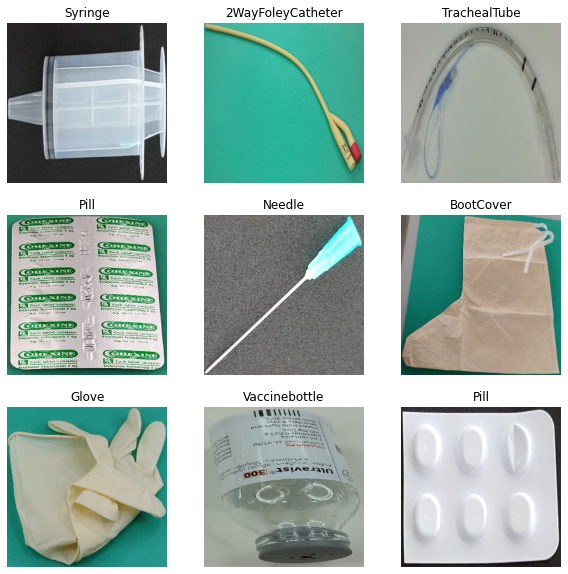

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [13]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(height_factor=0.1),
  layers.RandomContrast(0.05),
])

In [14]:
normalization_layer = layers.Rescaling(1./255)

#Apply the preprocessing layers to your dataset
AUTOTUNE = tf.data.AUTOTUNE
#train_ds = train_ds.cache().shuffle(2000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

def prepare(ds, shuffle=False, augment=False):
  # Normalize by 255 all datasets.
  ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(2000)

  # Batch all datasets.
  #ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
train_ds = prepare(train_ds, shuffle=True, augment=False)
val_ds = prepare(val_ds)
test_indoor_ds = prepare(test_indoor_ds)
test_outdoor_ds = prepare(test_outdoor_ds)
test_belt_ds = prepare(test_belt_ds)

In [16]:
# Test -> Fetching Mini Batch
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 299, 299, 3)
(64,)


In [17]:
'''
vgg16_model = keras.applications.vgg16.VGG16()
model = Sequential()

for layer in vgg16_model.layers[:-1]: # this is where I changed your code
    model.add(layer)    

# Freeze the layers 
for layer in model.layers:
    layer.trainable = False

# Add 'softmax' instead of earlier 'prediction' layer.
model.add(Dense(2, activation='softmax'))
'''
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
import numpy as np
from tensorflow.keras.layers import Dense, Input, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

inceptionv3_model = keras.applications.InceptionV3(input_shape=(img_height,img_width,3),include_top=True,weights="imagenet",classifier_activation="softmax")

inceptionv3_model_nooutput = inceptionv3_model.layers[-2].output
custom_inceptionv3_model = Model(inputs = inceptionv3_model.input, outputs = inceptionv3_model_nooutput)


## Freez Extractor+

In [18]:
custom_inceptionv3_model.trainable = False
for layer in custom_inceptionv3_model.layers:
    layer.trainable = False
## Freez
#custom_inceptionv3_model.layers[-1].trainable = True
#custom_inceptionv3_model.layers[-2].trainable = True
#custom_inceptionv3_model.layers[-3].trainable = True
print(custom_inceptionv3_model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [19]:
model = tf.keras.Sequential()
# Feature Extractor
model.add(custom_inceptionv3_model)
# Classifier
model.add(tf.keras.layers.Dense(len(class_names), activation='softmax', trainable=True))
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 2048)              21802784  
_________________________________________________________________
dense (Dense)                (None, 41)                84009     
Total params: 21,886,793
Trainable params: 84,009
Non-trainable params: 21,802,784
_________________________________________________________________


## Class Weight

In [21]:
y_train = np.concatenate([ y for x,y in train_ds],axis=0)

In [22]:
print(len(y_train))
print(y_train)

3095
[26 18  8 ... 14 28 19]


In [23]:
######################### Class Weight
from sklearn.utils import class_weight

# compute class weight 
# based on appearance of each class in y_trian
class_weight_value = class_weight.compute_class_weight(class_weight='balanced', classes=sorted(np.unique(y_train)), y=y_train)
# dict mapping
class_weight_value = {i : class_weight_value[i] for i, label in enumerate(sorted(np.unique(y_train)))}
print(class_weight_value)

{0: 5.806754221388368, 1: 2.220229555236729, 2: 2.040210942649967, 3: 4.193766937669377, 4: 1.9355847404627893, 5: 0.5510058750222538, 6: 4.440459110473458, 7: 2.156794425087108, 8: 2.287509238728751, 9: 1.9865211810012837, 10: 4.193766937669377, 11: 3.2820784729586427, 12: 2.695993031358885, 13: 2.156794425087108, 14: 3.9730423620025674, 15: 3.59465737514518, 16: 0.39730423620025673, 17: 4.717987804878049, 18: 0.3931656504065041, 19: 0.2755029375111269, 20: 1.451688555347092, 21: 1.3243474540008557, 22: 0.3682331945270672, 23: 1.5726626016260163, 24: 1.7555303460011344, 25: 0.46029149315883405, 26: 0.11685418711772257, 27: 0.9932605905006419, 28: 2.7958446251129176, 29: 4.440459110473458, 30: 2.516260162601626, 31: 1.0065040650406505, 32: 4.193766937669377, 33: 4.193766937669377, 34: 1.6061235080435912, 35: 2.516260162601626, 36: 0.5278867473989425, 37: 3.9730423620025674, 38: 3.774390243902439, 39: 0.6739982578397212, 40: 2.4350904799370574}


# Fitting

In [1]:
path_to_model = 'D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer-NoClassImabalance-NoAug-VerySlowLR2/'

In [25]:
EPOCHS = 2000
save_model_interval = 40
checkpoint_filepath = path_to_model+'OurOutputLayer-NoClassImbalanced-NoAug-epoch{epoch:04d}-val_acc{val_accuracy:.2f}.pb'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_freq='epoch',
    period=save_model_interval,
    save_best_only=False)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                  patience=5, min_lr=0.00001,cooldown=1, verbose=1)
# Model weights are saved at the end of every epoch, if it's the best seen
# so far.
history = model.fit(train_ds,validation_data=val_ds,epochs=EPOCHS, callbacks=[model_checkpoint_callback,reduce_lr]) #,class_weight=class_weight_value

Epoch 1/2000
49/49 [==============================] - 26s 327ms/step - loss: 1.9477 - accuracy: 0.5105 - val_loss: 0.9735 - val_accuracy: 0.7464
Epoch 2/2000
49/49 [==============================] - 9s 174ms/step - loss: 0.6682 - accuracy: 0.8511 - val_loss: 0.5671 - val_accuracy: 0.8603
Epoch 3/2000
49/49 [==============================] - 8s 174ms/step - loss: 0.3940 - accuracy: 0.9321 - val_loss: 0.4221 - val_accuracy: 0.8978
Epoch 4/2000
49/49 [==============================] - 9s 174ms/step - loss: 0.2769 - accuracy: 0.9557 - val_loss: 0.3456 - val_accuracy: 0.9185
Epoch 5/2000
49/49 [==============================] - 8s 174ms/step - loss: 0.2107 - accuracy: 0.9690 - val_loss: 0.2967 - val_accuracy: 0.9353
Epoch 6/2000
49/49 [==============================] - 8s 174ms/step - loss: 0.1679 - accuracy: 0.9790 - val_loss: 0.2626 - val_accuracy: 0.9470
Epoch 7/2000
49/49 [==============================] - 9s 174ms/step - loss: 0.1379 - accuracy: 0.9858 - val_loss: 0.2382 - val_accuracy

Text(0.5, 1.0, 'Training and Validation Accuracy')

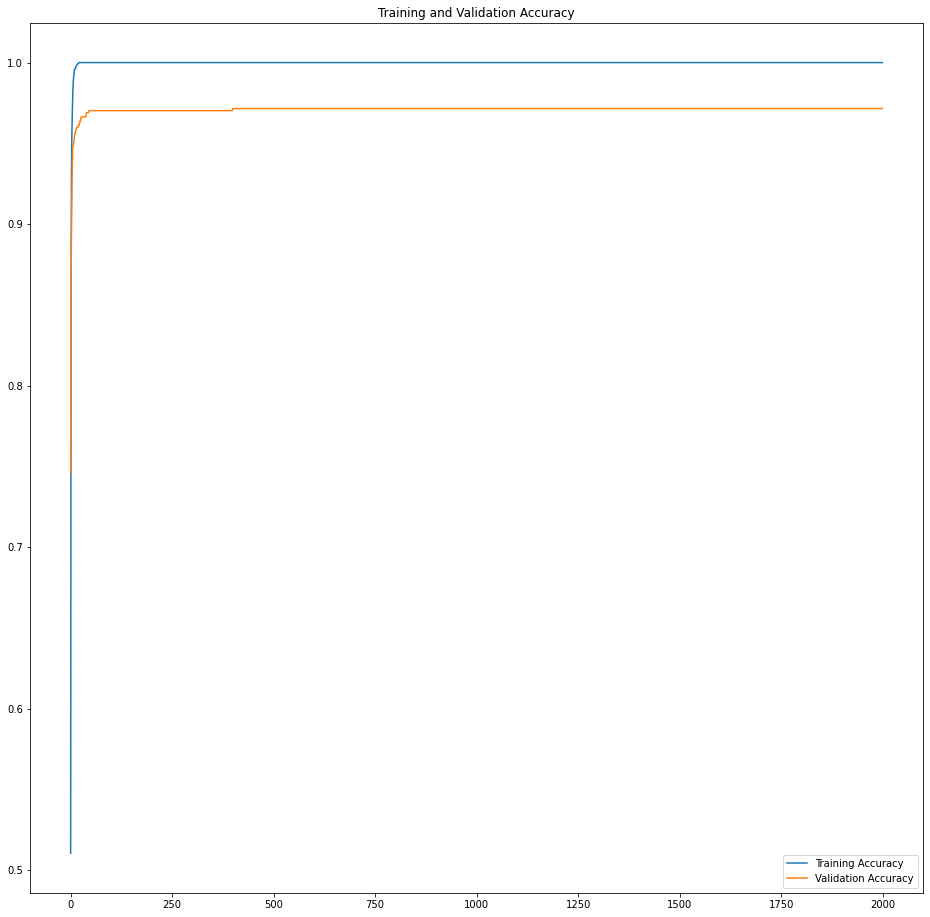

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 16))
#plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


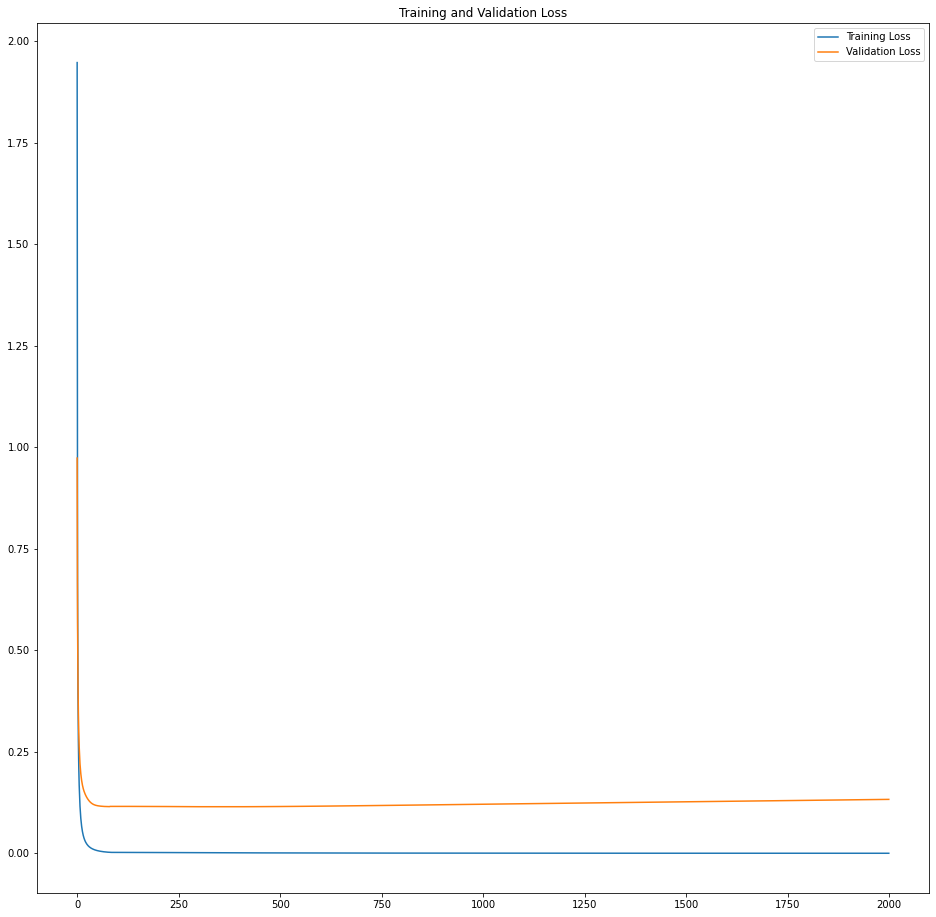

In [27]:
#plt.subplot(1, 2, 2)
plt.figure(figsize=(16, 16))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [28]:
#indoor testset
test_indoor_ds_results = model.evaluate(test_indoor_ds)
print("test_indoor_ds_results:test loss, test acc:", test_indoor_ds_results)

29/29 [==============================] - 14s 354ms/step - loss: 0.6944 - accuracy: 0.8501
test_indoor_ds_results:test loss, test acc: [0.6943652033805847, 0.8500557541847229]


In [29]:
#outdoor testset
test_outdoor_ds_results = model.evaluate(test_outdoor_ds)
print("test_outdoor_ds_results:test loss, test acc:", test_outdoor_ds_results)

50/50 [==============================] - 26s 431ms/step - loss: 1.8461 - accuracy: 0.7350
test_outdoor_ds_results:test loss, test acc: [1.8460780382156372, 0.7350318431854248]


In [30]:
#belt testset
test_belt_ds_results = model.evaluate(test_belt_ds)
print("test_belt_ds_results:test loss, test acc:", test_belt_ds_results)

35/35 [==============================] - 8s 195ms/step - loss: 2.0700 - accuracy: 0.6804
test_belt_ds_results:test loss, test acc: [2.0699644088745117, 0.6804170608520508]


In [31]:
# Read path of trained model
import os, os.path
trained_path = path_to_model
models_paths = []
for name_folder in os.listdir(trained_path):
    if os.path.isdir(os.path.join(trained_path, name_folder)):
        models_paths.append(os.path.join(trained_path, name_folder))
models_paths

['D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer-NoClassImabalance-NoAug-VerySlowLR2/OurOutputLayer-NoClassImbalanced-NoAug-epoch0040-val_acc0.97.pb',
 'D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer-NoClassImabalance-NoAug-VerySlowLR2/OurOutputLayer-NoClassImbalanced-NoAug-epoch0080-val_acc0.97.pb',
 'D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer-NoClassImabalance-NoAug-VerySlowLR2/OurOutputLayer-NoClassImbalanced-NoAug-epoch0120-val_acc0.97.pb',
 'D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer-NoClassImabalance-NoAug-VerySlowLR2/OurOutputLayer-NoClassImbalanced-NoAug-epoch0160-val_acc0.97.pb',
 'D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer-NoClassImabalance-NoAug-VerySlowLR2/OurOutputLayer-NoClassImbalanced-NoAug-epoch0200-val_acc0.97.pb',
 'D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer-NoClassImabalance-NoAug-VerySlowLR2/OurOutputLayer-NoClassImbalanced-N

# Testing in testset

In [32]:
test_indoor_acc = []
test_outdoor_acc = []
test_belt_acc = []
test_indoor_loss = []
test_outdoor_loss = []
test_belt_loss = []

for lm_idx,plmodel in enumerate(models_paths):
    loaded_model=tf.keras.models.load_model(plmodel)
    ## -> keep loss / acc in each epoch
    #indoor
    test_indoor_results = loaded_model.evaluate(test_indoor_ds)
    test_indoor_loss.append(test_indoor_results[0]) # append loss
    test_indoor_acc.append(test_indoor_results[1]) # append acc
    #outdoor
    test_outdoor_results = loaded_model.evaluate(test_outdoor_ds)
    test_outdoor_loss.append(test_outdoor_results[0]) # append loss
    test_outdoor_acc.append(test_outdoor_results[1]) # append acc
    #belt
    test_belt_results = loaded_model.evaluate(test_belt_ds)
    test_belt_loss.append(test_belt_results[0]) # append loss
    test_belt_acc.append(test_belt_results[1]) # append acc
    # printout
    lm_idx_show = (lm_idx+1) * save_model_interval
    print(f"Epoch{lm_idx_show:03d} \n test_indoor_acc={test_indoor_acc[lm_idx]} \n test_outdoor_acc={test_outdoor_acc[lm_idx]} \n test_belt_acc={test_belt_acc[lm_idx]}")

35/35 [==============================] - 5s 141ms/step - loss: 1.3473 - accuracy: 0.6655
Epoch040 
 test_indoor_acc=0.8322185277938843 
 test_outdoor_acc=0.7347133755683899 
 test_belt_acc=0.6654578447341919
35/35 [==============================] - 5s 140ms/step - loss: 1.4637 - accuracy: 0.6686
Epoch080 
 test_indoor_acc=0.8450390100479126 
 test_outdoor_acc=0.7359872460365295 
 test_belt_acc=0.6686310172080994
35/35 [==============================] - 5s 142ms/step - loss: 1.4528 - accuracy: 0.6700
Epoch120 
 test_indoor_acc=0.846711277961731 
 test_outdoor_acc=0.7382165789604187 
 test_belt_acc=0.6699909567832947
35/35 [==============================] - 5s 140ms/step - loss: 1.4563 - accuracy: 0.6714
Epoch160 
 test_indoor_acc=0.846711277961731 
 test_outdoor_acc=0.7385350465774536 
 test_belt_acc=0.6713508367538452
35/35 [==============================] - 5s 141ms/step - loss: 1.4634 - accuracy: 0.6723
Epoch200 
 test_indoor_acc=0.846711277961731 
 test_outdoor_acc=0.739171981811523

In [33]:
#Average
test_avg_acc = []
for i in range(len(test_indoor_acc)):
    tmp_avg = (test_indoor_acc[i] + test_outdoor_acc[i] + test_belt_acc[i]) / 3.0
    test_avg_acc.append(tmp_avg)

range(40, 2040, 40)


Text(0.5, 1.0, 'Testing(EvaluationModel) Accuracy')

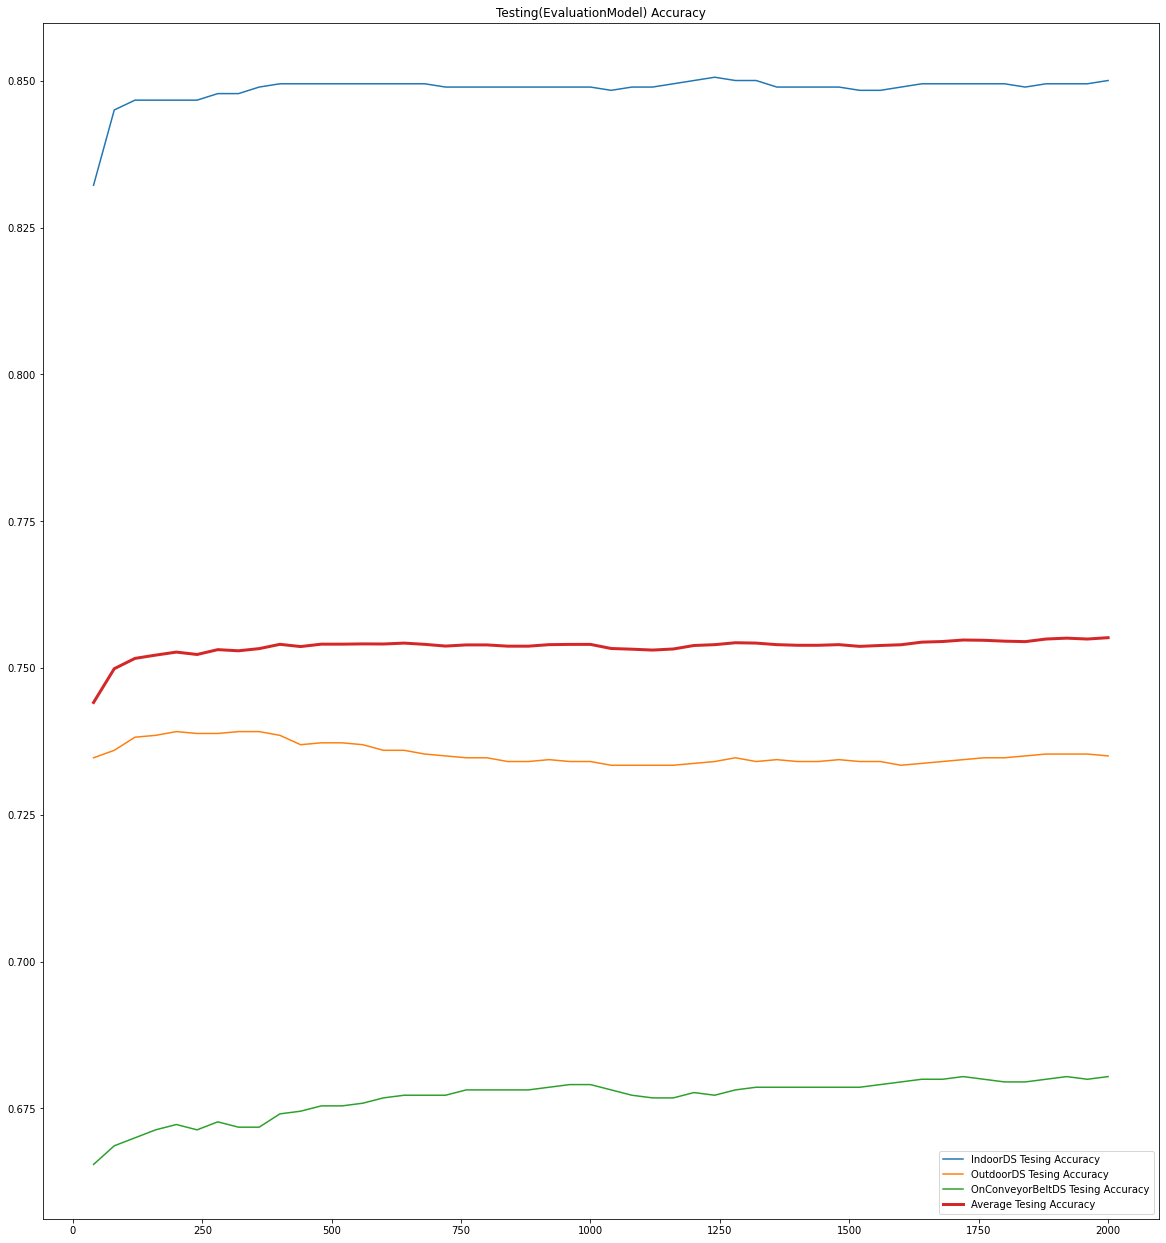

In [34]:
# loss / acc in each epoch graph ploting
import matplotlib.pyplot as plt
epochs_range = range(save_model_interval,EPOCHS+save_model_interval,save_model_interval)
print(epochs_range)
plt.figure(figsize=(20, 22))
#plt.subplot(1, 2, 1)
plt.plot(epochs_range, test_indoor_acc, label='IndoorDS Tesing Accuracy')
plt.plot(epochs_range, test_outdoor_acc, label='OutdoorDS Tesing Accuracy')
plt.plot(epochs_range, test_belt_acc, label='OnConveyorBeltDS Tesing Accuracy')
plt.plot(epochs_range, test_avg_acc, label='Average Tesing Accuracy',linewidth=3)
plt.legend(loc='lower right')
plt.title('Testing(EvaluationModel) Accuracy')

In [35]:
#Find Max Index and Value
print(f"max acc -> {max(test_avg_acc)}")
max_index = test_avg_acc.index(max(test_avg_acc))
print(f"max index -> {max_index}")
print(f"The [Epoch] of max acc -> {(max_index+1)*save_model_interval}")

max acc -> 0.7551682194073995
max index -> 49
The [Epoch] of max acc -> 2000


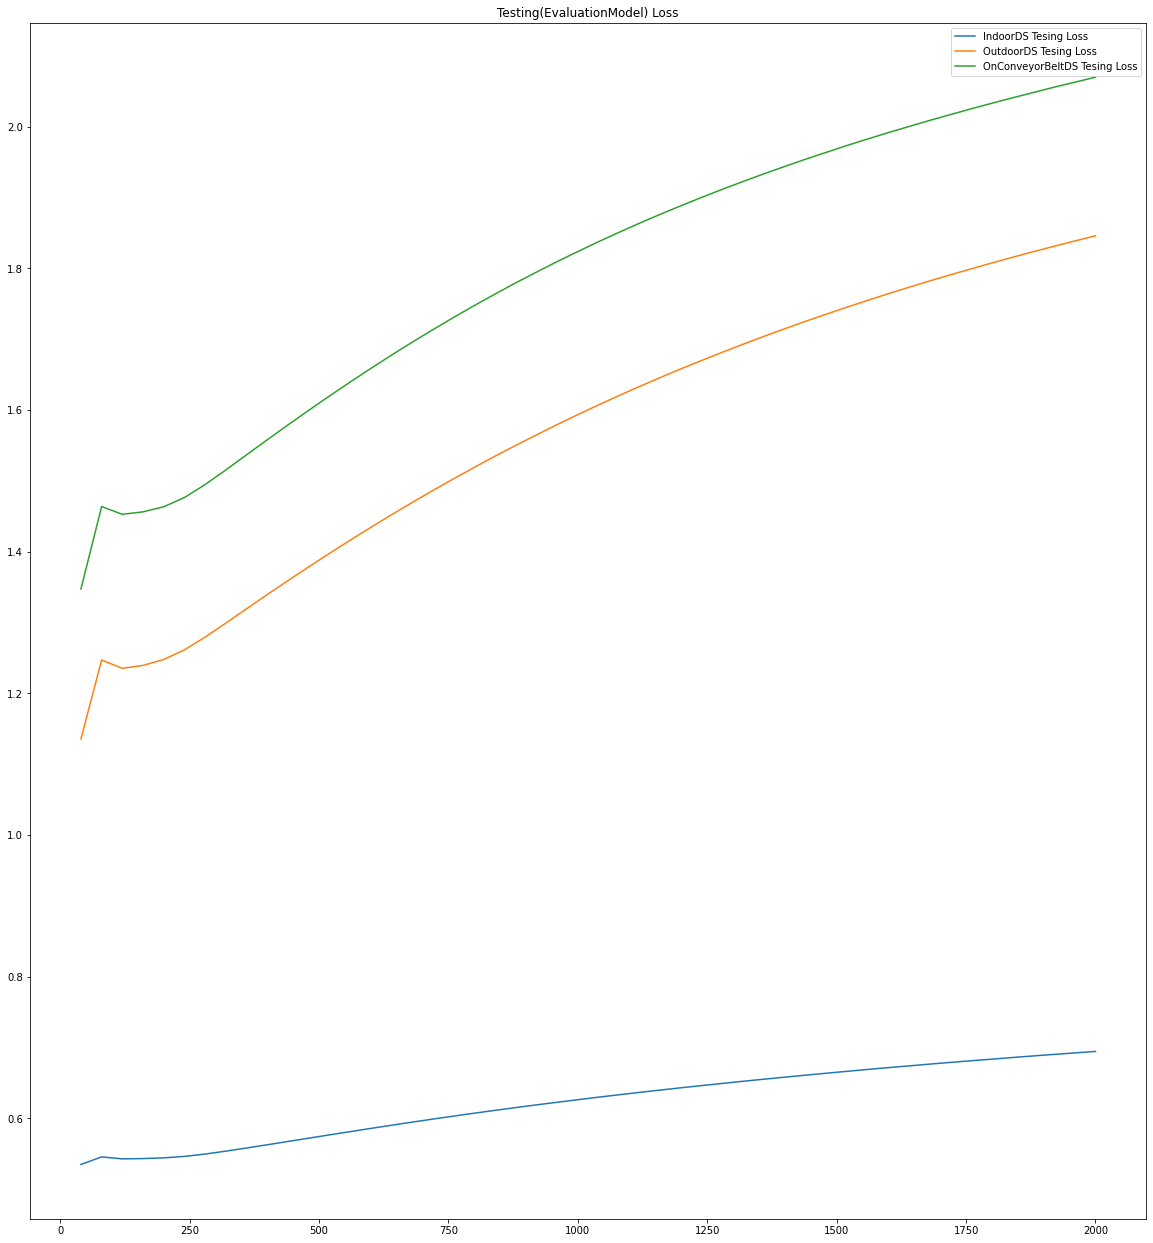

In [36]:
plt.figure(figsize=(20, 22))
#plt.subplot(1, 2, 2)
plt.plot(epochs_range, test_indoor_loss, label='IndoorDS Tesing Loss')
plt.plot(epochs_range, test_outdoor_loss, label='OutdoorDS Tesing Loss')
plt.plot(epochs_range, test_belt_loss, label='OnConveyorBeltDS Tesing Loss')
plt.legend(loc='upper right')
plt.title('Testing(EvaluationModel) Loss')
plt.show()

In [37]:
test_indoor_acc

[0.8322185277938843,
 0.8450390100479126,
 0.846711277961731,
 0.846711277961731,
 0.846711277961731,
 0.846711277961731,
 0.8478260636329651,
 0.8478260636329651,
 0.848940908908844,
 0.8494983315467834,
 0.8494983315467834,
 0.8494983315467834,
 0.8494983315467834,
 0.8494983315467834,
 0.8494983315467834,
 0.8494983315467834,
 0.8494983315467834,
 0.848940908908844,
 0.848940908908844,
 0.848940908908844,
 0.848940908908844,
 0.848940908908844,
 0.848940908908844,
 0.848940908908844,
 0.848940908908844,
 0.8483834862709045,
 0.848940908908844,
 0.848940908908844,
 0.8494983315467834,
 0.8500557541847229,
 0.8506131768226624,
 0.8500557541847229,
 0.8500557541847229,
 0.848940908908844,
 0.848940908908844,
 0.848940908908844,
 0.848940908908844,
 0.8483834862709045,
 0.8483834862709045,
 0.848940908908844,
 0.8494983315467834,
 0.8494983315467834,
 0.8494983315467834,
 0.8494983315467834,
 0.8494983315467834,
 0.848940908908844,
 0.8494983315467834,
 0.8494983315467834,
 0.8494983315

In [38]:
test_outdoor_acc

[0.7347133755683899,
 0.7359872460365295,
 0.7382165789604187,
 0.7385350465774536,
 0.7391719818115234,
 0.7388535141944885,
 0.7388535141944885,
 0.7391719818115234,
 0.7391719818115234,
 0.7385350465774536,
 0.7369426488876343,
 0.737261176109314,
 0.737261176109314,
 0.7369426488876343,
 0.7359872460365295,
 0.7359872460365295,
 0.7353503108024597,
 0.7350318431854248,
 0.7347133755683899,
 0.7347133755683899,
 0.7340764403343201,
 0.7340764403343201,
 0.734394907951355,
 0.7340764403343201,
 0.7340764403343201,
 0.7334395051002502,
 0.7334395051002502,
 0.7334395051002502,
 0.7334395051002502,
 0.7337579727172852,
 0.7340764403343201,
 0.7347133755683899,
 0.7340764403343201,
 0.734394907951355,
 0.7340764403343201,
 0.7340764403343201,
 0.734394907951355,
 0.7340764403343201,
 0.7340764403343201,
 0.7334395051002502,
 0.7337579727172852,
 0.7340764403343201,
 0.734394907951355,
 0.7347133755683899,
 0.7347133755683899,
 0.7350318431854248,
 0.7353503108024597,
 0.7353503108024597

In [39]:
test_belt_acc

[0.6654578447341919,
 0.6686310172080994,
 0.6699909567832947,
 0.6713508367538452,
 0.6722574830055237,
 0.6713508367538452,
 0.6727107763290405,
 0.6718041896820068,
 0.6718041896820068,
 0.6740707159042358,
 0.6745240092277527,
 0.6754306554794312,
 0.6754306554794312,
 0.675883948802948,
 0.6767905950546265,
 0.6772438883781433,
 0.6772438883781433,
 0.6772438883781433,
 0.678150475025177,
 0.678150475025177,
 0.678150475025177,
 0.678150475025177,
 0.6786038279533386,
 0.6790571212768555,
 0.6790571212768555,
 0.678150475025177,
 0.6772438883781433,
 0.6767905950546265,
 0.6767905950546265,
 0.6776971817016602,
 0.6772438883781433,
 0.678150475025177,
 0.6786038279533386,
 0.6786038279533386,
 0.6786038279533386,
 0.6786038279533386,
 0.6786038279533386,
 0.6786038279533386,
 0.6790571212768555,
 0.6795104146003723,
 0.6799637079238892,
 0.6799637079238892,
 0.6804170608520508,
 0.6799637079238892,
 0.6795104146003723,
 0.6795104146003723,
 0.6799637079238892,
 0.6804170608520508,

In [40]:
test_indoor_loss

[0.5347993969917297,
 0.5454123616218567,
 0.5426762700080872,
 0.5430812239646912,
 0.5441088676452637,
 0.5461591482162476,
 0.5494701266288757,
 0.5535658597946167,
 0.5580133199691772,
 0.5625951886177063,
 0.5672319531440735,
 0.5718849301338196,
 0.5765155553817749,
 0.5811174511909485,
 0.5856553316116333,
 0.5901513695716858,
 0.5945404767990112,
 0.5988477468490601,
 0.6030425429344177,
 0.6071711182594299,
 0.6111792922019958,
 0.6151008009910583,
 0.6188884973526001,
 0.6226012706756592,
 0.6262161731719971,
 0.6297865509986877,
 0.6332176327705383,
 0.6366308331489563,
 0.6398842930793762,
 0.6431066989898682,
 0.646220862865448,
 0.6492605805397034,
 0.6522768139839172,
 0.6552104353904724,
 0.6580459475517273,
 0.6608679890632629,
 0.663605809211731,
 0.666297435760498,
 0.6689688563346863,
 0.6715041399002075,
 0.6739875674247742,
 0.6764794588088989,
 0.6788727641105652,
 0.6812337636947632,
 0.6834748983383179,
 0.6857885122299194,
 0.6880163550376892,
 0.6901757717132

In [41]:
test_outdoor_loss

[1.1355602741241455,
 1.2470250129699707,
 1.2353012561798096,
 1.239466905593872,
 1.2478108406066895,
 1.2614340782165527,
 1.2794290781021118,
 1.299226999282837,
 1.31942880153656,
 1.3395285606384277,
 1.3591947555541992,
 1.3785492181777954,
 1.3975809812545776,
 1.4161635637283325,
 1.4343352317810059,
 1.4521554708480835,
 1.469495177268982,
 1.4864871501922607,
 1.5030165910720825,
 1.519147515296936,
 1.5348429679870605,
 1.5501625537872314,
 1.5649423599243164,
 1.5795423984527588,
 1.5935231447219849,
 1.607285976409912,
 1.6206070184707642,
 1.633589506149292,
 1.646155834197998,
 1.658431053161621,
 1.6702733039855957,
 1.681904673576355,
 1.6931884288787842,
 1.7042057514190674,
 1.714858055114746,
 1.725355625152588,
 1.7353919744491577,
 1.7452702522277832,
 1.754917860031128,
 1.7643470764160156,
 1.7734266519546509,
 1.7824256420135498,
 1.7910128831863403,
 1.7994792461395264,
 1.807765245437622,
 1.8157989978790283,
 1.8236867189407349,
 1.8312798738479614,
 1.8387

In [42]:
test_belt_loss

[1.3473378419876099,
 1.4637433290481567,
 1.452788233757019,
 1.4562808275222778,
 1.463444709777832,
 1.476506233215332,
 1.4947859048843384,
 1.5155012607574463,
 1.536808729171753,
 1.558078408241272,
 1.5790126323699951,
 1.5995829105377197,
 1.6197669506072998,
 1.639530897140503,
 1.6587271690368652,
 1.6775585412979126,
 1.695819616317749,
 1.7135882377624512,
 1.730841875076294,
 1.7476049661636353,
 1.7638075351715088,
 1.7796300649642944,
 1.79476797580719,
 1.809651494026184,
 1.8238213062286377,
 1.8377563953399658,
 1.8511091470718384,
 1.8641759157180786,
 1.8766859769821167,
 1.8887364864349365,
 1.900528907775879,
 1.911980152130127,
 1.9230071306228638,
 1.9337059259414673,
 1.9440793991088867,
 1.954245924949646,
 1.9639167785644531,
 1.9735984802246094,
 1.9828011989593506,
 1.9918265342712402,
 2.0004591941833496,
 2.0090537071228027,
 2.0172529220581055,
 2.025411367416382,
 2.033283233642578,
 2.0409629344940186,
 2.048410177230835,
 2.0558981895446777,
 2.062941

## Load Last Epoch and test in each class

In [57]:
# Del dataset memory and reload
# RAM
del train_ds
del val_ds
del test_indoor_ds
del test_outdoor_ds
del test_belt_ds
# VRAM
from numba import cuda
cuda.select_device(0)
cuda.close()

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
import numpy as np
from keras.applications.vgg16 import preprocess_input

last_epoch_model = tf.keras.models.load_model(path_to_model+'OurOutputLayer-NoClassImbalanced-NoAug-epoch2000-val_acc0.97.pb')

test_indoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/indoor'
test_outdoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/outdoor'
test_belt_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/belt'

img_height=299
img_width=299
batch_size=64

test_indoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_indoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_outdoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_outdoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_belt_ds = tf.keras.utils.image_dataset_from_directory(
  test_belt_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

normalization_layer = layers.Rescaling(1./255)

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(height_factor=0.1),
  layers.RandomContrast(0.05),
])

#Apply the preprocessing layers to your dataset
AUTOTUNE = tf.data.AUTOTUNE
#train_ds = train_ds.cache().shuffle(2000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

def prepare(ds, shuffle=False, augment=False):
  # Normalize by 255 all datasets.
  ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(2000)

  # Batch all datasets.
  #ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.cache().prefetch(buffer_size=AUTOTUNE)

test_indoor_ds = prepare(test_indoor_ds)
test_outdoor_ds = prepare(test_outdoor_ds)
test_belt_ds = prepare(test_belt_ds)

class_names = ['1WayConnectorforFoley', '2WayConnectorforFoley', '2WayFoleyCatheter', '3WayConnectorforFoley', '3Waystopcock', 'AlcoholBottle', 'AlcoholPad', 'BootCover', 'CottonBall', 'CottonSwap', 'Dilator', 'DisposableInfusionSet', 'ExtensionTube', 'FaceShield', 'FrontLoadSyringe', 'GauzePad', 'Glove', 'GuideWire', 'LiquidBottle', 'Mask', 'NGTube', 'NasalCannula', 'Needle', 'OxygenMask', 'PPESuit', 'PharmaceuticalProduct', 'Pill', 'PillBottle', 'PrefilledHumidifier', 'PressureConnectingTube', 'ReusableHumidifier', 'SodiumChlorideBag', 'SterileHumidifierAdapter', 'SurgicalBlade', 'SurgicalCap', 'SurgicalSuit', 'Syringe', 'TrachealTube', 'UrineBag', 'Vaccinebottle', 'WingedInfusionSet']

x_test_indoor = np.concatenate([ x for x,y in test_indoor_ds],axis=0)
x_test_outdoor = np.concatenate([ x for x,y in test_outdoor_ds],axis=0)
x_test_belt = np.concatenate([ x for x,y in test_belt_ds],axis=0)
y_test_indoor = np.concatenate([ y for x,y in test_indoor_ds],axis=0)
y_test_outdoor = np.concatenate([ y for x,y in test_outdoor_ds],axis=0)
y_test_belt = np.concatenate([ y for x,y in test_belt_ds],axis=0)
print(f"train_indoor num x,y : {len(x_test_indoor)},{len(y_test_indoor)}")
print(f"train_outdoor num x,y : {len(x_test_outdoor)},{len(y_test_outdoor)}")
print(f"train_belt num x,y : {len(x_test_belt)},{len(y_test_belt)}")
x_all = np.concatenate([x_test_indoor,x_test_outdoor,x_test_belt],axis=0)
y_all = np.concatenate([y_test_indoor,y_test_outdoor,y_test_belt],axis=0)
print(f"all num x,y :{len(x_all)},{len(y_all)}")
# let's predict
y_all_predicted = last_epoch_model.predict(x_all,batch_size=128)

Found 1794 files belonging to 41 classes.
Found 3140 files belonging to 41 classes.
Found 2206 files belonging to 41 classes.
train_indoor num x,y : 1794,1794
train_outdoor num x,y : 3140,3140
train_belt num x,y : 2206,2206
all num x,y :7140,7140


In [3]:
y_all_predicted_max = np.array([],dtype=np.int)
# acc all
TP = 0
FP = 0
for i in range(len(y_all)):
    if(y_all[i]==np.argmax(y_all_predicted[i])):
        TP = TP + 1
    else :
        FP = FP + 1
    y_all_predicted_max=np.append(y_all_predicted_max,np.argmax(y_all_predicted[i]))
print(f'all={TP+FP}')
print(f'TP={TP}')
print(f'FP={FP}')
print(f'acc={TP/(TP+FP)}')

# acc eachclass
TP_eachclass = [0] * 41
FP_eachclass = [0] * 41
for i in range(len(y_all)):
    if(y_all[i]==np.argmax(y_all_predicted[i])):
        TP_eachclass[y_all[i]] = TP_eachclass[y_all[i]] + 1
    else :
        FP_eachclass[y_all[i]] = FP_eachclass[y_all[i]] + 1
#recheck
print(f'all check = {sum(TP_eachclass)+sum(FP_eachclass)}')

all=7140
TP=5336
FP=1804
acc=0.7473389355742297
all check = 7140


In [4]:
avg_acc_eachclass = []
for i in range(len(class_names)):
    print(f'{class_names[i]} acc = {TP_eachclass[i]/(TP_eachclass[i]+FP_eachclass[i])*100}%')
    avg_acc_eachclass.append(TP_eachclass[i]/(TP_eachclass[i]+FP_eachclass[i])*100)
all_avg_eachclass = sum(avg_acc_eachclass) / len(avg_acc_eachclass)
print(f'\n\n\nall_avg_eachclass = {all_avg_eachclass}%')


1WayConnectorforFoley acc = 72.41379310344827%
2WayConnectorforFoley acc = 90.47619047619048%
2WayFoleyCatheter acc = 70.8955223880597%
3WayConnectorforFoley acc = 93.16239316239316%
3Waystopcock acc = 100.0%
AlcoholBottle acc = 86.875%
AlcoholPad acc = 45.23809523809524%
BootCover acc = 62.048192771084345%
CottonBall acc = 74.8502994011976%
CottonSwap acc = 78.32167832167832%
Dilator acc = 69.23076923076923%
DisposableInfusionSet acc = 53.98230088495575%
ExtensionTube acc = 37.39837398373984%
FaceShield acc = 70.37037037037037%
FrontLoadSyringe acc = 61.06194690265486%
GauzePad acc = 59.09090909090909%
Glove acc = 74.70238095238095%
GuideWire acc = 32.142857142857146%
LiquidBottle acc = 63.358778625954194%
Mask acc = 93.24675324675324%
NGTube acc = 43.87096774193549%
NasalCannula acc = 68.14159292035397%
Needle acc = 81.78571428571428%
OxygenMask acc = 98.49624060150376%
PPESuit acc = 95.96774193548387%
PharmaceuticalProduct acc = 63.3177570093458%
Pill acc = 96.9187675070028%
PillBot

In [5]:
# for plotting
import matplotlib.pyplot as plt
# for using scikit-learn's built-in metrics
from sklearn.metrics import *
# for using tesnorflow/keras' built-in metrics
import tensorflow.keras.backend as K
''' ndarray of shape (n_classes, n_classes)
Confusion matrix whose i-th row and j-th column entry indicates the number of samples with  {true label being i-th row class} and {predicted label being column j-th class}.
> Example
>>> y_true = ["cat", "ant", "cat", "cat", "ant", "bird"]
>>> y_pred = ["ant", "ant", "cat", "cat", "ant", "cat"]
>>> confusion_matrix(y_true, y_pred, labels=["ant", "bird", "cat"])
array([[2, 0, 0],
       [0, 0, 1],
       [1, 0, 2]])
พุดง่ายๆ แถวคือด้านความจริง
       หลักคือด้านที่ระบบทำนาย
'''
# 
confusionMat = confusion_matrix(y_all, y_all_predicted_max, labels=range(len(class_names)))
confusionMat

array([[ 84,   0,   0, ...,   0,   1,   0],
       [  1, 133,   0, ...,   0,   1,   0],
       [  0,   0,  95, ...,   0,   3,   6],
       ...,
       [  0,   0,   0, ...,  70,   1,   1],
       [  0,   0,   0, ...,   0, 178,   0],
       [  0,   1,   0, ...,   0,   2,  76]], dtype=int64)

In [6]:
confusionMatFloat = confusionMat.astype('float64')
confusionMatFloatPercent=confusionMatFloat/confusionMatFloat.sum(axis=1)[:,None]  # divided by number of sample in each class (sum of each row)
confusionMatFloatPercent*=100
confusionMatFloatPercent

array([[72.4137931 ,  0.        ,  0.        , ...,  0.        ,
         0.86206897,  0.        ],
       [ 0.68027211, 90.47619048,  0.        , ...,  0.        ,
         0.68027211,  0.        ],
       [ 0.        ,  0.        , 70.89552239, ...,  0.        ,
         2.23880597,  4.47761194],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., 58.33333333,
         0.83333333,  0.83333333],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        83.56807512,  0.        ],
       [ 0.        ,  0.87719298,  0.        , ...,  0.        ,
         1.75438596, 66.66666667]])

<AxesSubplot:>

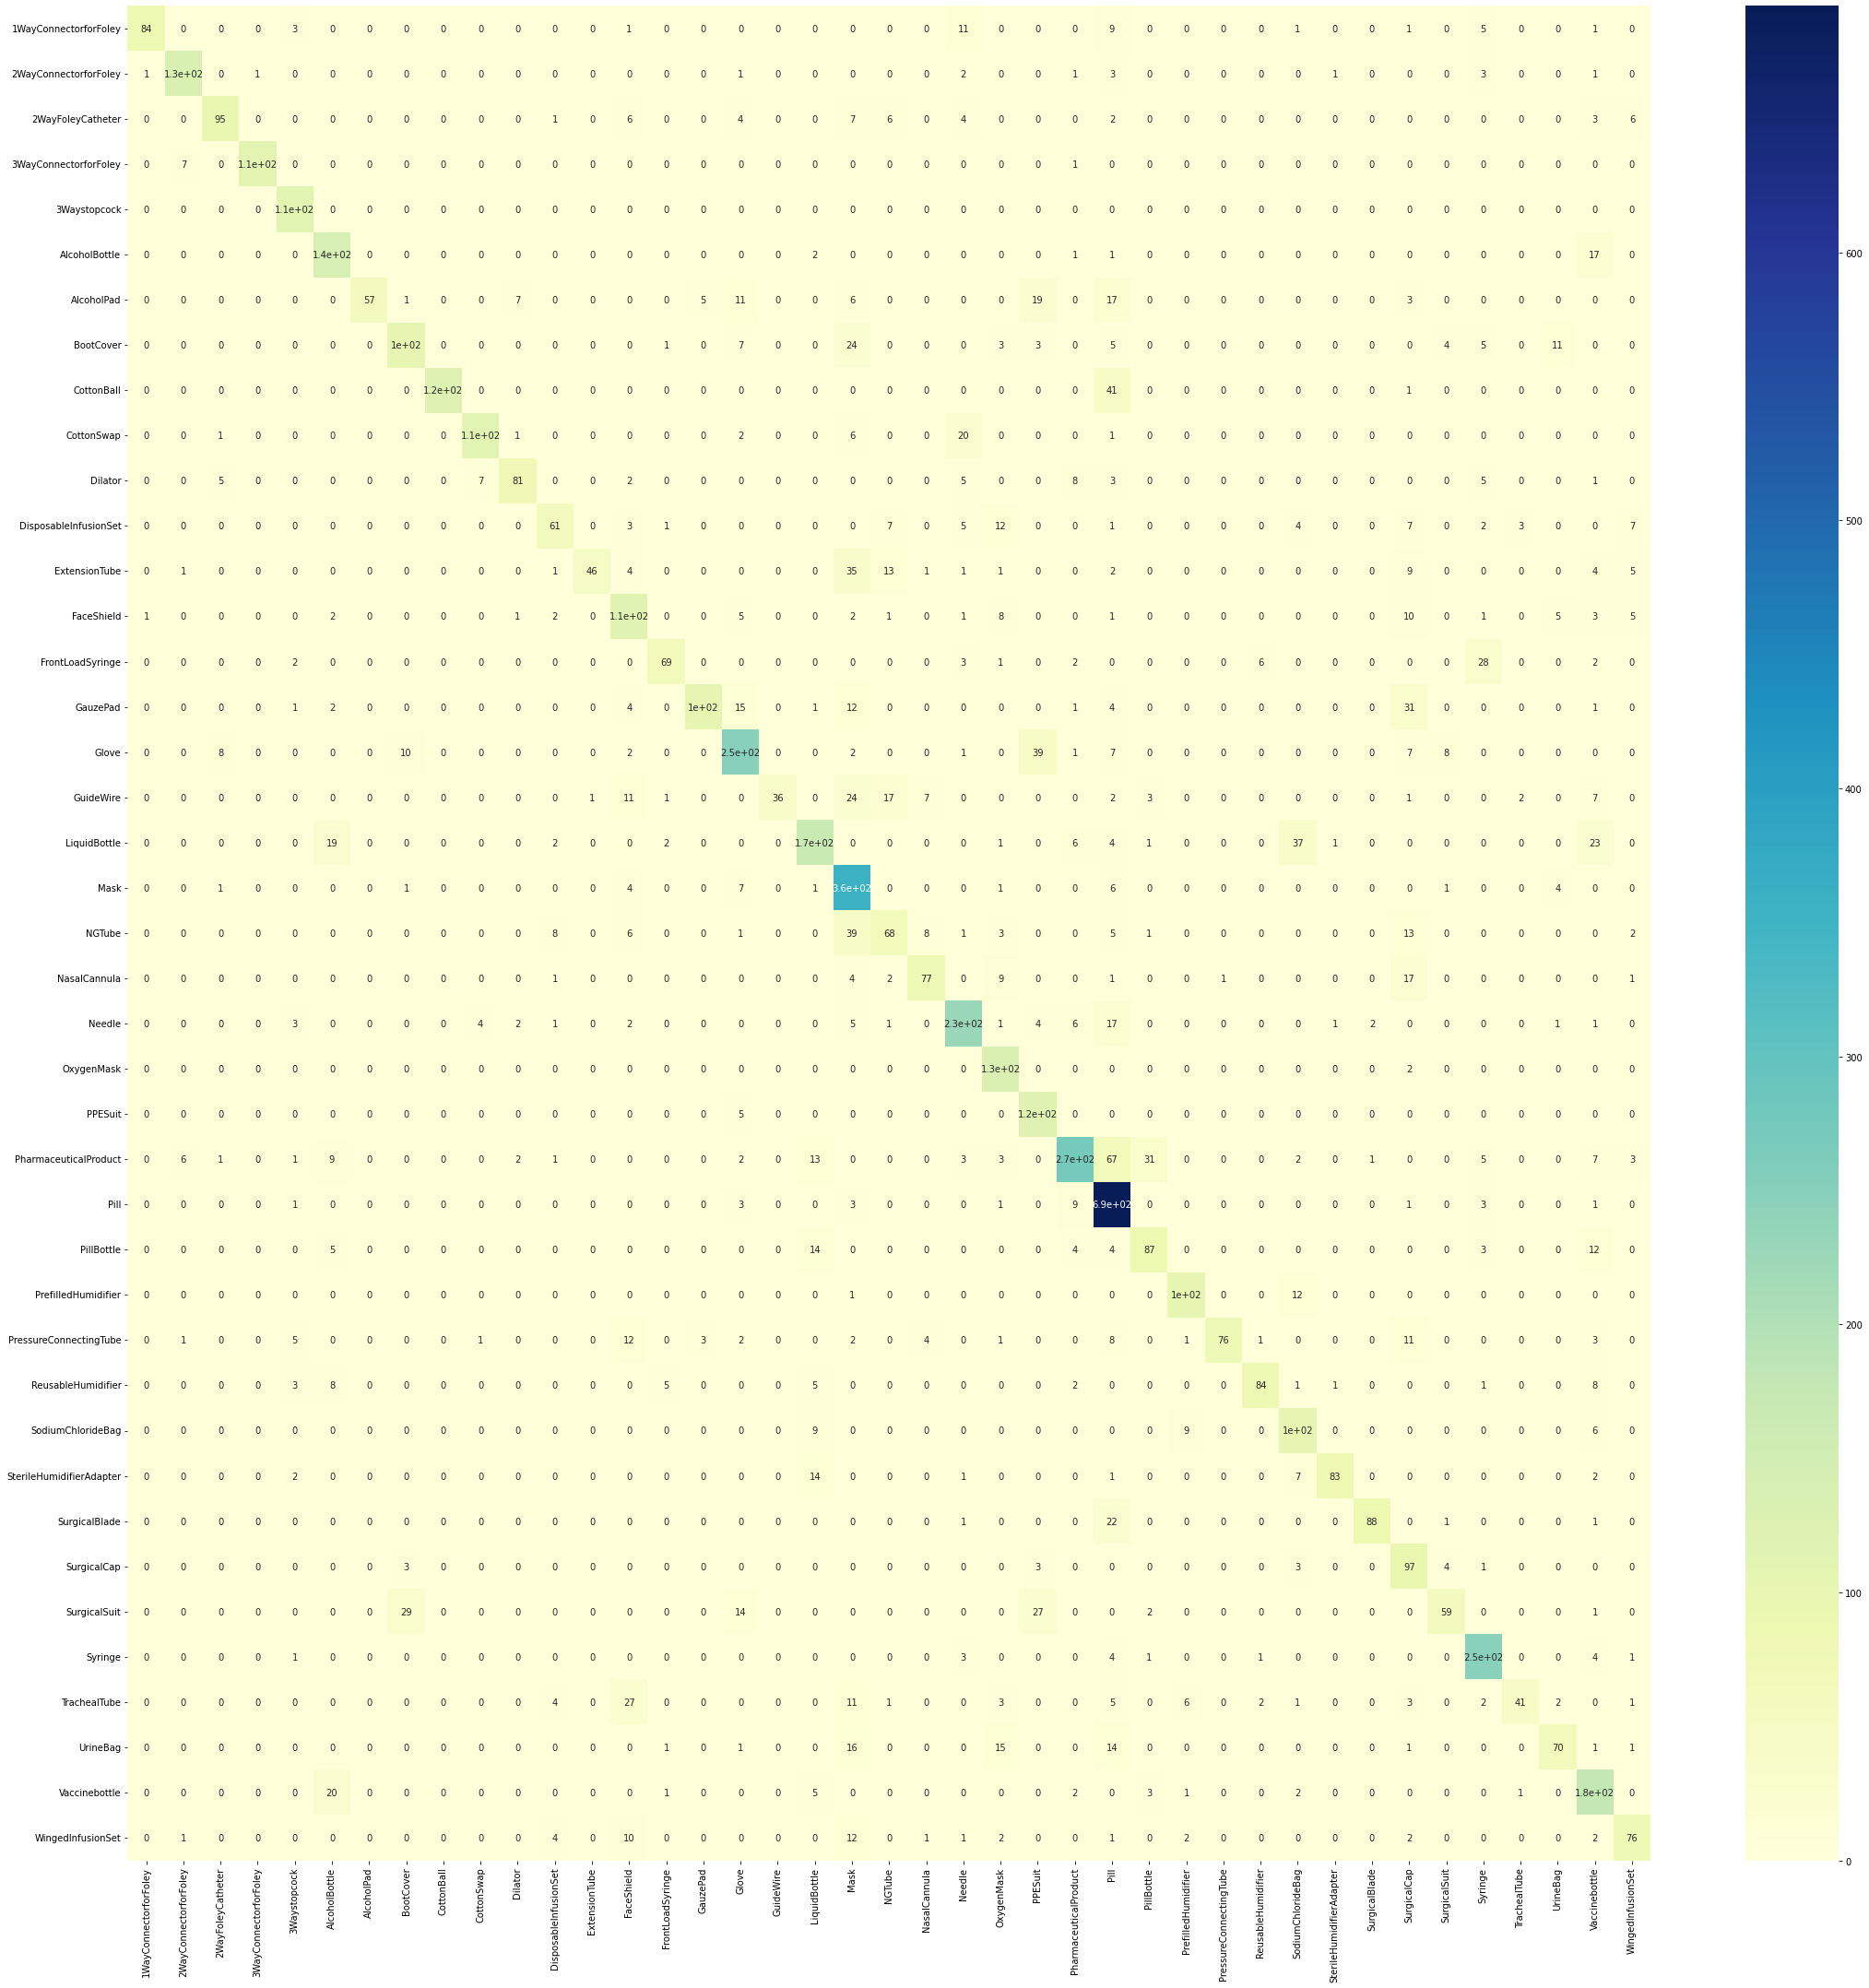

In [7]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(confusionMat, index = class_names,
                  columns = class_names)
plt.figure(figsize = (37,37))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu")

<AxesSubplot:>

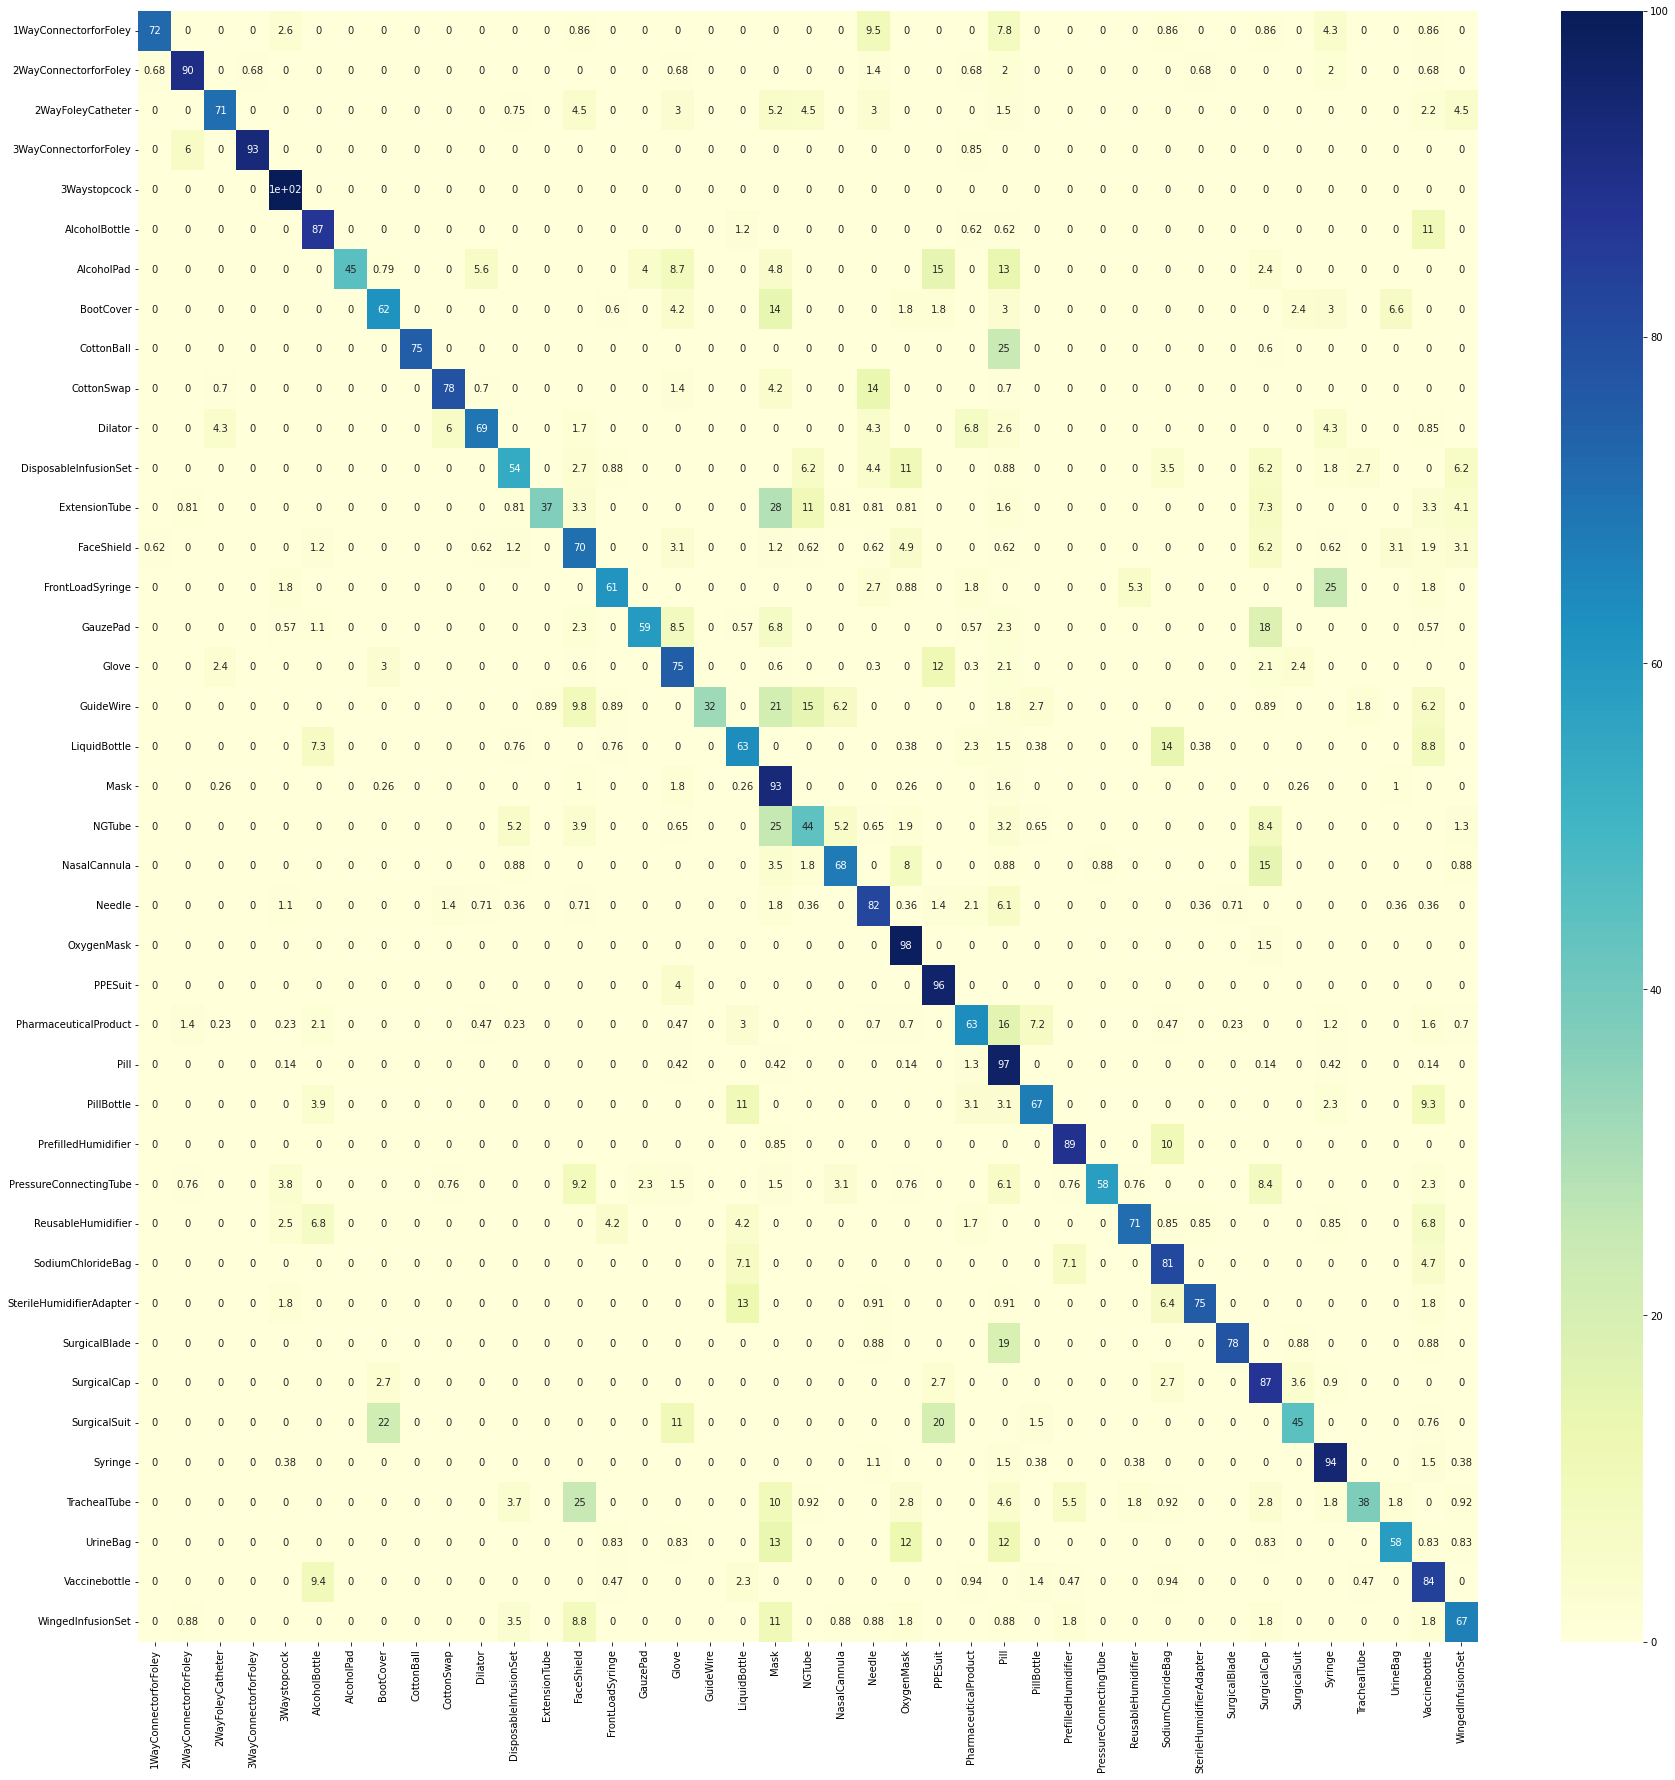

In [8]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(confusionMatFloatPercent, index = class_names,
                  columns = class_names)
plt.figure(figsize = (30,30))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu")